In [554]:
# import dependencies
import numpy as np
import scipy as sp
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl
import datetime as dt
import requests
from random import sample

#from icecream import ic

import os
from dotenv import load_dotenv

# from ta import add_all_ta_features
# from ta.trend import MACD
# from ta.volatility import BollingerBands
# from ta.volume import VolumeWeightedAveragePrice
# from ta.momentum import StochRSIIndicator

In [555]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [556]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [557]:
# load API keys from .env file
load_dotenv()
TRADIER_TOKEN = os.getenv('TRADIER_TOKEN')
EOD_TOKEN = os.getenv('EOD_TOKEN')

### Get Tickers

In [558]:
def get_etf_tickers(): 
    
    # pulls all tickers of ETFs on NYSE or NASDAQ

    r = requests.get('https://eodhistoricaldata.com/api/exchange-symbol-list/US', 
        params={'api_token': EOD_TOKEN, 'fmt': 'json'}
        )
    data = r.json()
    r.close()

    df = pd.DataFrame(data)
    #print(df.head())
    df = df[
        (df.Type == 'Common Stock') &
        ((df.Exchange == 'NYSE ARCA') |
        (df.Exchange == 'NASDAQ'))
        ]

    df.index = df.Code
    df.drop('Code', axis = 1, inplace=True)
    ticker_list = list(df.index)
    return ticker_list

In [559]:
# get etf tickers
tickers = get_etf_tickers()

In [560]:
# save ticker list to csv
df = pd.DataFrame(tickers)
df.to_csv('data/tickers.csv')

### Get Historical Price: Daily

In [561]:
def get_historical_price(tickers, data_type):

    # pulls historical daily or intraday OLHC prices and volume

    d = {}
    e = {}

    for i in range(len(tickers)): 

        r = requests.get('https://eodhistoricaldata.com/api' + '/' + data_type + '/' + tickers[i] + '.US', 
            params={'api_token': EOD_TOKEN, 'fmt': 'json'}
            )
        data = r.json()
        r.close()

        d[tickers[i]] = data

        # ADD PROGRESS BAR
        
        # remove unecessary loop
        d[tickers[i]] = pd.DataFrame.from_records(data)
        d[tickers[i]] = d[tickers[i]].set_index('date')
        e[tickers[i]] = d[tickers[i]]['adjusted_close']

        if i % 10 == 0:
            print(i)
    return e

In [562]:
# placeholder tickers
# tickers = ['SPXS', 'SPXL']

# Prints list of random items of given length 
#tickers_sample = sample(tickers, 50)

tickers_sample = ['MSFT', 'AMZN', 'AAPL', 'JBHT', 'GS', 'JPM', 'CSX']

# get daily prices | dictionary of dataframes
daily_data = get_historical_price(tickers_sample, 'eod')

0


In [563]:
# concat daily dataframes together and convert to dask df
daily_df = pd.concat(daily_data.values(), axis=1, keys=daily_data.keys())
daily_dask_df = dd.from_pandas(daily_df, npartitions=6)

#daily_df.to_csv('data/test_daily_df.csv')

In [564]:
prices = daily_df.copy()

## Get Stock Fundementals

In [565]:
def get_stock_fundmentals(tickers): 

    raw_data = {}
    all_clean_data = {}

    columns = ['General', 'Highlights']

    for i in range(len(tickers)): 

        single_ticker_clean_data = {}

        r = requests.get('https://eodhistoricaldata.com/api/fundamentals/' + tickers[i] + '.US', 
            params={'api_token': '63dc0e2f4efc43.34327983', 'fmt': 'json'}
            )
        data = r.json()
        
        r.close()

        raw_data[tickers[i]] = data
        
        Officers = raw_data[tickers[i]]['General'].pop('Officers', None)
        Listings = raw_data[tickers[i]]['General'].pop('Listings', None)
        AddressData = raw_data[tickers[i]]['General'].pop('AddressData', None)
        NumberDividendsByYear = raw_data[tickers[i]]['SplitsDividends'].pop('NumberDividendsByYear', None)

        columns = ['General', 'Highlights', 'Valuation', 'SharesStats',
            'Technicals','SplitsDividends', 'AnalystRatings']
        for name in columns:
            single_ticker_clean_data[name] = pd.Series(raw_data[tickers[i]][name])

        columns = ['Institutions', 'Funds']
        for name in columns:
            single_ticker_clean_data[name] = pd.DataFrame(
                raw_data[tickers[i]]['Holders'][name]).T.set_index(['name'])
        single_ticker_clean_data['Holders'] = pd.concat([single_ticker_clean_data['Institutions'], single_ticker_clean_data['Funds']],
            keys=['Institutions','Funds'])
        Institutions = single_ticker_clean_data.pop('Institutions', None)
        Funds = single_ticker_clean_data.pop('Funds', None)

        single_ticker_clean_data['InsiderTransactions'] = pd.DataFrame(
            raw_data[tickers[i]]['InsiderTransactions']).T.set_index(['date'])

        columns = ['annual', 'quarterly']
        for name in columns:
            single_ticker_clean_data[name] = pd.DataFrame(
                raw_data[tickers[i]]['outstandingShares'][name]).T.set_index(['dateFormatted'])
        single_ticker_clean_data['outstandingShares'] = single_ticker_clean_data['quarterly'].join(
            single_ticker_clean_data['annual'], lsuffix='_quarterly', rsuffix='_annual')
        Institutions = single_ticker_clean_data.pop('quarterly', None)
        Funds = single_ticker_clean_data.pop('annual', None)

        # join on date
        columns = ['History', 'Trend', 'Annual']
        for name in columns:
            single_ticker_clean_data[name] = pd.DataFrame(raw_data[tickers[i]]['Earnings'][name]).T
        single_ticker_clean_data['Earnings'] = pd.concat([single_ticker_clean_data['History'], 
            single_ticker_clean_data['Trend'], single_ticker_clean_data['Annual']],
            keys=['History', 'Trend', 'Annual'], axis=1)
        History = single_ticker_clean_data.pop('History', None)
        Trend = single_ticker_clean_data.pop('Trend', None)
        Annual = single_ticker_clean_data.pop('Annual', None)

        statements = ['Balance_Sheet', 'Income_Statement', 'Cash_Flow']
        period = ['quarterly', 'yearly']

        for statement in statements:
            for time in period:
                # join on date
                single_ticker_clean_data[statement + time] = pd.DataFrame(
                    raw_data[tickers[i]]['Financials'][statement][time]).T

        # single_ticker_clean_data['Balance_Sheet'] = fundemental_data['Balance_Sheetquarterly'].join(
        #     fundemental_data['Balance_Sheetyearly'], lsuffix='_quarterly', rsuffix='_annual')
        single_ticker_clean_data['Balance_Sheet'] = pd.concat([single_ticker_clean_data['Balance_Sheetquarterly'], 
            single_ticker_clean_data['Balance_Sheetyearly']],
            keys=['Quarterly', 'Yearly'], axis=1)
        Balance_Sheetyearly = single_ticker_clean_data.pop('Balance_Sheetyearly', None)
        Balance_Sheetquarterly = single_ticker_clean_data.pop('Balance_Sheetquarterly', None)

        single_ticker_clean_data['Income_Statement'] = pd.concat([single_ticker_clean_data['Income_Statementquarterly'], 
            single_ticker_clean_data['Income_Statementyearly']],
            keys=['Quarterly', 'Yearly'], axis=1)
        Income_Statementyearly = single_ticker_clean_data.pop('Income_Statementyearly', None)
        Income_Statementquarterly = single_ticker_clean_data.pop('Income_Statementquarterly', None)

        
        single_ticker_clean_data['Cash_Flow'] = pd.concat([single_ticker_clean_data['Cash_Flowquarterly'], 
            single_ticker_clean_data['Cash_Flowyearly']],
            keys=['Quarterly', 'Yearly'], axis=1)
        Cash_Flowyearly = single_ticker_clean_data.pop('Cash_Flowyearly', None)
        Cash_Flowquarterly = single_ticker_clean_data.pop('Cash_Flowquarterly', None)

        all_clean_data[tickers[i]] = single_ticker_clean_data

        
        if i % 10 == 0:
            print(i)
        print(tickers[i])



    return all_clean_data

In [566]:
tickers_sample = sample(tickers, 31)

In [567]:
tickers_sample = ['MSFT', 'AMZN', 'AAPL', 'JBHT', 'GS', 'JPM', 'CSX']
stock_fundemental_data  = get_stock_fundmentals(tickers_sample)

0
MSFT
AMZN
AAPL
JBHT
GS
JPM
CSX


In [568]:
a = []
for ticker in tickers_sample:
    a.append(np.array([stock_fundemental_data[ticker]['Highlights'].MarketCapitalization,
             stock_fundemental_data[ticker]['General'].Sector,
             stock_fundemental_data[ticker]['General'].IPODate]))

In [569]:
stocks = pd.DataFrame(a, index = tickers_sample, columns = ['MktCap', 'Sector', 'IPODate'])

In [570]:
prices.head()

,MSFT,AMZN,AAPL,JBHT,GS,JPM,CSX
date,,,,,,,
1986-03-13,0.0607,NaN,0.0859,2.1128,NaN,4.3630,0.4850
1986-03-14,0.0629,NaN,0.0906,2.1423,NaN,4.3738,0.4968
1986-03-17,0.0640,NaN,0.0902,2.0980,NaN,4.4060,0.4901
1986-03-18,0.0623,NaN,0.0932,2.1423,NaN,4.2985,0.4935
1986-03-19,0.0612,NaN,0.0919,2.0980,NaN,4.4060,0.4867


In [571]:
stocks.head()

,MktCap,Sector,IPODate
MSFT,1920947060736,Technology,1986-03-13
AMZN,996037558272,Consumer Cyclical,1997-05-15
AAPL,2413630849024,Technology,1980-12-12
JBHT,19539994624,Industrials,1990-03-26
GS,124199608320,Financial Services,1999-05-03


In [572]:
a = []
for i in range(len(stocks)):
    year = stocks.IPODate[i][0:4]
    a.append(year)

a = pd.Series(a, name = 'IPOYear', index = stocks.index)

In [573]:
stocks = stocks.join(a)

In [574]:
stocks = stocks.drop('IPODate', axis = 1)

In [575]:
stocks.head()

,MktCap,Sector,IPOYear
MSFT,1920947060736,Technology,1986
AMZN,996037558272,Consumer Cyclical,1997
AAPL,2413630849024,Technology,1980
JBHT,19539994624,Industrials,1990
GS,124199608320,Financial Services,1999


## Feature Engineering

In [576]:
shared = prices.columns.intersection(stocks.index)

In [577]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, MSFT to CSX
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MktCap   7 non-null      object
 1   Sector   7 non-null      object
 2   IPOYear  7 non-null      object
dtypes: object(3)
memory usage: 524.0+ bytes


In [578]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10664 entries, 1986-03-13 to 1980-12-11
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    9311 non-null   float64
 1   AMZN    6485 non-null   float64
 2   AAPL    10637 non-null  float64
 3   JBHT    9647 non-null   float64
 4   GS      5990 non-null   float64
 5   JPM     9651 non-null   float64
 6   CSX     10664 non-null  float64
dtypes: float64(7)
memory usage: 666.5+ KB


In [579]:
assert prices.shape[1] == stocks.shape[0]

In [580]:
prices.index = pd.to_datetime(prices.index)

In [581]:
monthly_prices = prices.resample('M').last()

In [582]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 1980-11-30 to 2023-02-28
Freq: M
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    444 non-null    float64
 1   AMZN    310 non-null    float64
 2   AAPL    507 non-null    float64
 3   JBHT    460 non-null    float64
 4   GS      286 non-null    float64
 5   JPM     460 non-null    float64
 6   CSX     508 non-null    float64
dtypes: float64(7)
memory usage: 31.8 KB


In [583]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('CSX', Timestamp('1981-11-30 00:00:00', freq='M')) to ('CSX', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2891 non-null   float64
 1   return_2m   2891 non-null   float64
 2   return_3m   2891 non-null   float64
 3   return_6m   2891 non-null   float64
 4   return_9m   2891 non-null   float64
 5   return_12m  2891 non-null   float64
dtypes: float64(6)
memory usage: 164.5+ KB


In [584]:
idx = pd.IndexSlice

In [585]:
min_obs = 120
nobs = data.groupby(level=0).size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2891 non-null   float64
 1   return_2m   2891 non-null   float64
 2   return_3m   2891 non-null   float64
 3   return_6m   2891 non-null   float64
 4   return_9m   2891 non-null   float64
 5   return_12m  2891 non-null   float64
dtypes: float64(6)
memory usage: 164.5+ KB


In [586]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000,2891.000000
mean,0.017538,0.015199,0.014283,0.013474,0.013221,0.013219
std,0.098162,0.070953,0.058339,0.041881,0.034432,0.029747
min,-0.254700,-0.194128,-0.165826,-0.107561,-0.083930,-0.069260
25%,-0.042318,-0.023766,-0.018023,-0.010096,-0.006238,-0.004477
50%,0.016225,0.016140,0.015124,0.013829,0.013285,0.012750
75%,0.072502,0.054399,0.046914,0.036231,0.032020,0.029981
max,0.304381,0.229885,0.183271,0.147638,0.123650,0.104596


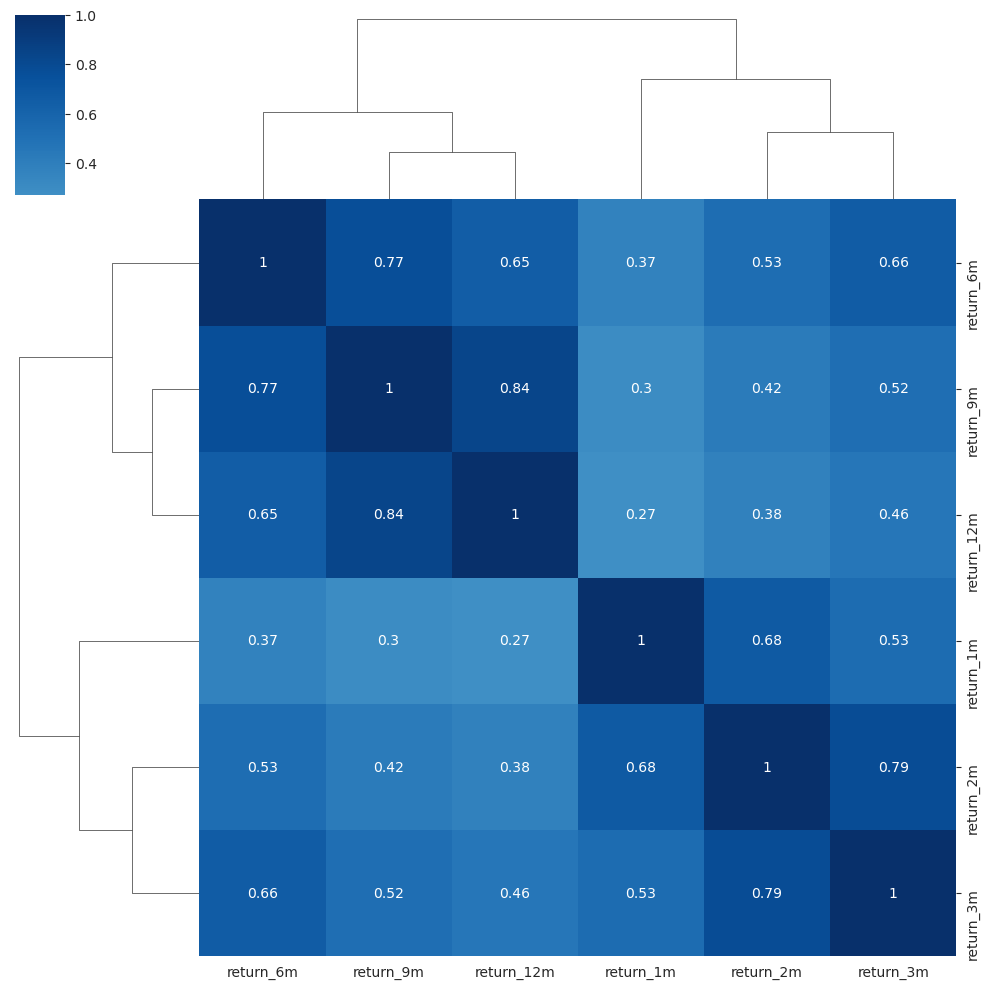

In [587]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [588]:
data.index.get_level_values(0).nunique()

7

In [589]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2000-01-31 to 2022-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  276 non-null    float64
 1   SMB     276 non-null    float64
 2   HML     276 non-null    float64
 3   RMW     276 non-null    float64
 4   CMA     276 non-null    float64
dtypes: float64(5)
memory usage: 12.9 KB


In [590]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1928 entries, ('AAPL', Timestamp('2000-01-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2022-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     1928 non-null   float64
 1   SMB        1928 non-null   float64
 2   HML        1928 non-null   float64
 3   RMW        1928 non-null   float64
 4   CMA        1928 non-null   float64
 5   return_1m  1928 non-null   float64
dtypes: float64(6)
memory usage: 106.4+ KB


In [591]:
T = 24
betas = (factor_data.groupby(level=0,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [592]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,1767.000000,1767.000000,1767.000000,1767.000000,1767.000000,1928.000000
mean,1.198949,-0.031197,0.124250,-0.017170,-0.702548,0.524496
std,0.625986,0.852158,1.243881,1.223052,1.448881,2.015283
min,-0.626368,-4.274044,-5.418950,-6.132401,-7.440267,-8.658027
25%,0.902446,-0.489997,-0.628650,-0.740318,-1.474121,-0.384794
50%,1.163111,-0.069251,0.155142,-0.030184,-0.678417,0.572061
75%,1.440000,0.423617,0.843304,0.592991,0.222258,1.775177
max,6.183256,3.474062,4.096165,4.411289,3.557425,8.524077


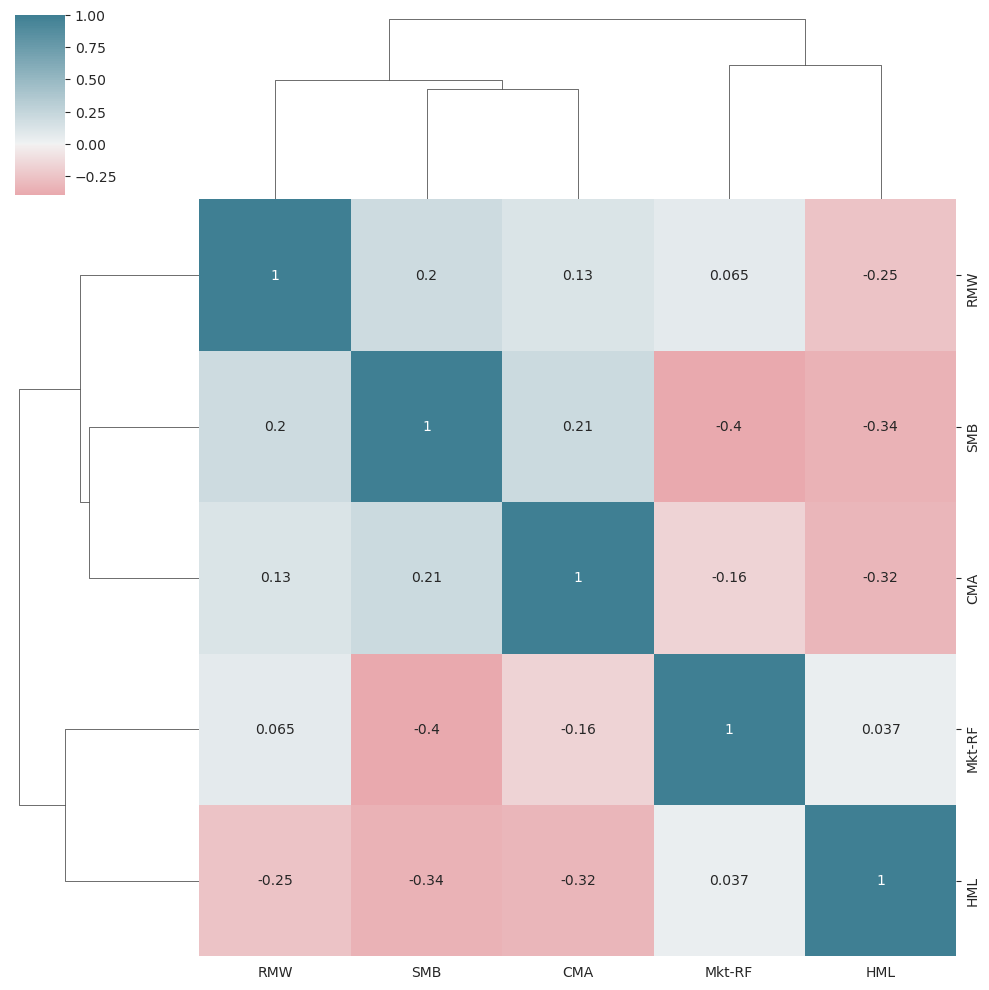

In [593]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [594]:
data = (data
        .join(betas
              .groupby(level=0)
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2891 non-null   float64
 1   return_2m   2891 non-null   float64
 2   return_3m   2891 non-null   float64
 3   return_6m   2891 non-null   float64
 4   return_9m   2891 non-null   float64
 5   return_12m  2891 non-null   float64
 6   Mkt-RF      1760 non-null   float64
 7   SMB         1760 non-null   float64
 8   HML         1760 non-null   float64
 9   RMW         1760 non-null   float64
 10  CMA         1760 non-null   float64
dtypes: float64(11)
memory usage: 342.0+ KB


In [595]:
data.loc[:, factors] = data.groupby(level=0)[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   2891 non-null   float64
 1   return_2m   2891 non-null   float64
 2   return_3m   2891 non-null   float64
 3   return_6m   2891 non-null   float64
 4   return_9m   2891 non-null   float64
 5   return_12m  2891 non-null   float64
 6   Mkt-RF      2891 non-null   float64
 7   SMB         2891 non-null   float64
 8   HML         2891 non-null   float64
 9   RMW         2891 non-null   float64
 10  CMA         2891 non-null   float64
dtypes: float64(11)
memory usage: 342.0+ KB


In [596]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

In [597]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [598]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level=0).return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      2891 non-null   float64
 1   return_2m      2891 non-null   float64
 2   return_3m      2891 non-null   float64
 3   return_6m      2891 non-null   float64
 4   return_9m      2891 non-null   float64
 5   return_12m     2891 non-null   float64
 6   Mkt-RF         2891 non-null   float64
 7   SMB            2891 non-null   float64
 8   HML            2891 non-null   float64
 9   RMW            2891 non-null   float64
 10  CMA            2891 non-null   float64
 11  momentum_2     2891 non-null   float64
 12  momentum_3     2891 non-null   float64
 13  momentum_6     2891 non-null   float64
 14  momentum_9     2891 non-null   float64
 15  momentum_12    2891 non-null   float64
 1

In [599]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level=0)[f'return_{t}m'].shift(-t)

In [600]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
     date                                                                
AAPL 1982-03-31  -0.126496  -0.088535  -0.089202  -0.075829  -0.090363   
     1982-04-30  -0.048924  -0.069962  -0.028184  -0.126496  -0.101520   
     1982-05-31  -0.090535  -0.017645   0.087463  -0.048924  -0.088535   
     1982-06-30   0.061086   0.189129   0.127181  -0.090535  -0.069962   
     1982-07-31   0.304381   0.161757   0.183271   0.061086  -0.017645   
     1982-08-31   0.012800   0.186592   0.183271   0.304381   0.189129   
     1982-09-30   0.304381   0.229885   0.178849   0.012800   0.161757   
     1982-10-31   0.256818   0.085546   0.172370   0.304381   0.186592   
     1982-11-30  -0.062387   0.132298   0.126960   0.256818   0.229885   
     1982-12-31   0.304381   0.229885   0.122324  -0.062387   0.085546   

                 return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
     date                                                                
AAPL 1982-03-31  -0.086732      -0.104668      -0.079427       0.188854  
     1982-04-30  -0.102570      -0.075829      -0.104668      -0.079427  
     1982-05-31  -0.084319      -0.126496      -0.075829      -0.104668  
     1982-06-30  -0.089202      -0.048924      -0.126496      -0.075829  
     1982-07-31  -0.028184      -0.090535      -0.048924      -0.126496  
     1982-08-31   0.087463       0.061086      -0.090535      -0.048924  
     1982-09-30   0.127181       0.304381       0.061086      -0.090535  
     1982-10-31   0.183271       0.012800       0.304381       0.061086  
     1982-11-30   0.183271       0.304381       0.012800       0.304381  
     1982-12-31   0.178849       0.256818       0.304381       0.012800

In [601]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      2891 non-null   float64
 1   return_2m      2891 non-null   float64
 2   return_3m      2891 non-null   float64
 3   return_6m      2891 non-null   float64
 4   return_9m      2891 non-null   float64
 5   return_12m     2891 non-null   float64
 6   Mkt-RF         2891 non-null   float64
 7   SMB            2891 non-null   float64
 8   HML            2891 non-null   float64
 9   RMW            2891 non-null   float64
 10  CMA            2891 non-null   float64
 11  momentum_2     2891 non-null   float64
 12  momentum_3     2891 non-null   float64
 13  momentum_6     2891 non-null   float64
 14  momentum_9     2891 non-null   float64
 15  momentum_12    2891 non-null   float64
 1

In [602]:
data = (data
        .join(pd.qcut(stocks['IPOYear'].astype('int64'), q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age'), on = data.index.get_level_values(0)))
data.age = data.age.fillna(-1)

In [603]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values(1).unique(),
                    data.index.get_level_values(0).unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2023-02-28 to 1981-11-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    496 non-null    float64
 1   AMZN    496 non-null    float64
 2   CSX     496 non-null    float64
 3   GS      496 non-null    float64
 4   JBHT    496 non-null    float64
 5   JPM     496 non-null    float64
 6   MSFT    496 non-null    float64
dtypes: float64(7)
memory usage: 31.0 KB


In [604]:
stocks = stocks.astype({'MktCap': 'float64'})

In [605]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'MktCap'])).dropna(axis=1, how='all')

In [606]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

/home/groovyjac/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:432: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))
/home/groovyjac/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:432: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))
/home/groovyjac/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:432: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))
/home/groovyjac/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:432: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))
/home/groovyjac/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:432: Runt

In [607]:
data = data.join(stocks[['Sector']], on = data.index.get_level_values(0))
data.Sector = data.Sector.fillna('Unknown')

In [608]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      2891 non-null   float64
 1   return_2m      2891 non-null   float64
 2   return_3m      2891 non-null   float64
 3   return_6m      2891 non-null   float64
 4   return_9m      2891 non-null   float64
 5   return_12m     2891 non-null   float64
 6   Mkt-RF         2891 non-null   float64
 7   SMB            2891 non-null   float64
 8   HML            2891 non-null   float64
 9   RMW            2891 non-null   float64
 10  CMA            2891 non-null   float64
 11  momentum_2     2891 non-null   float64
 12  momentum_3     2891 non-null   float64
 13  momentum_6     2891 non-null   float64
 14  momentum_9     2891 non-null   float64
 15  momentum_12    2891 non-null   float64
 1

In [609]:
data.head()

return_1m  return_2m  return_3m  return_6m  return_9m  \
     date                                                                
AAPL 1981-12-31   0.188854   0.051964   0.132318  -0.026448  -0.011209   
     1982-01-31  -0.079427   0.046149   0.006205  -0.033430  -0.036175   
     1982-02-28  -0.104668  -0.092135  -0.006753  -0.016159  -0.064096   
     1982-03-31  -0.075829  -0.090363  -0.086732   0.016912  -0.046972   
     1982-04-30  -0.126496  -0.101520  -0.102570  -0.049738  -0.057049   

                 return_12m    Mkt-RF       SMB       HML       RMW  ...  \
     date                                                            ...   
AAPL 1981-12-31   -0.035361  1.409111 -0.154644  0.063213  0.419035  ...   
     1982-01-31   -0.026843  1.409111 -0.154644  0.063213  0.419035  ...   
     1982-02-28   -0.030590  1.409111 -0.154644  0.063213  0.419035  ...   
     1982-03-31   -0.030656  1.409111 -0.154644  0.063213  0.419035  ...   
     1982-04-30   -0.053221  1.409111 -0.154644  0.063213  0.419035  ...   

                 return_1m_t-5  return_1m_t-6  target_1m  target_2m  \
     date                                                             
AAPL 1981-12-31            NaN            NaN  -0.079427  -0.092135   
     1982-01-31            NaN            NaN  -0.104668  -0.090363   
     1982-02-28            NaN            NaN  -0.075829  -0.101520   
     1982-03-31            NaN            NaN  -0.126496  -0.088535   
     1982-04-30            NaN            NaN  -0.048924  -0.069962   

                 target_3m  target_6m  target_12m  age  msize      Sector  
     date                                                                  
AAPL 1981-12-31  -0.086732  -0.087968    0.025341    1      7  Technology  
     1982-01-31  -0.102570  -0.066117    0.059713    1      7  Technology  
     1982-02-28  -0.084319  -0.002118    0.079377    1      7  Technology  
     1982-03-31  -0.089202   0.013230    0.079563    1      7  Technology  
     1982-04-30  -0.028184   0.094822    0.104596    1      7  Technology  

[5 rows x 33 columns]

In [613]:
DATA_STORE = 'data/assets.h5'

In [614]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/assets.h5
/engineered_features            frame        (shape->[2471,33])


In [616]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'Sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2891 entries, ('AAPL', Timestamp('1981-12-31 00:00:00', freq='M')) to ('MSFT', Timestamp('2023-02-28 00:00:00', freq='M'))
Data columns (total 98 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   return_1m           2891 non-null   float64
 1   return_2m           2891 non-null   float64
 2   return_3m           2891 non-null   float64
 3   return_6m           2891 non-null   float64
 4   return_9m           2891 non-null   float64
 5   return_12m          2891 non-null   float64
 6   Mkt-RF              2891 non-null   float64
 7   SMB                 2891 non-null   float64
 8   HML                 2891 non-null   float64
 9   RMW                 2891 non-null   float64
 10  CMA                 2891 non-null   float64
 11  momentum_2          2891 non-null   float64
 12  momentum_3          2891 non-null   float64
 13  momentum_6          2891 non-null   float64
 14  momen